# Dataset Augmentation Pipeline

This notebook augments the VLoad dataset for weight estimation (**walk videos only**):

**Pipeline:**
1. **Split**: Each video → 4 clips (part1, part2, part3, part4)
2. **Flip**: Each clip → original + horizontal flip
3. **Pad**: All videos padded to same frame count

**Result:** 72 walk videos → **576 videos** (8x multiplication)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import os
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video, display, HTML

# Set working directory
os.chdir(r"/kaggle/input/viload")
print(f"Working directory: {os.getcwd()}")

Working directory: /kaggle/input/viload


In [3]:
import sys 
sys.path.append("/kaggle/input/viload")

## 1. Explore Original Dataset

In [ ]:
# Analyze original dataset
input_dir = Path("/kaggle/input/viload/drive-download-20260125T111807Z-1-001/dataset_weight_estimation/dataset_weight_estimation")

classes = ["empty", "light", "heavy"]
operators = [f"ope{i}" for i in range(1, 9)]
actions = ["walk"]  # Only walk videos (excluding carry)
angles = ["angle1", "angle2", "angle3"]

# Count videos and analyze frames
video_info = []

for cls in classes:
    for ope in operators:
        for action in actions:
            for angle in angles:
                video_path = input_dir / cls / ope / action / f"{angle}.mp4"
                if video_path.exists():
                    cap = cv2.VideoCapture(str(video_path))
                    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    fps = int(cap.get(cv2.CAP_PROP_FPS))
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    cap.release()
                    
                    video_info.append({
                        "class": cls,
                        "operator": ope,
                        "action": action,
                        "angle": angle,
                        "frames": frames,
                        "fps": fps,
                        "resolution": f"{width}x{height}"
                    })

print(f"Total videos found: {len(video_info)}")
print(f"Expected: {len(classes) * len(operators) * len(actions) * len(angles)} = 72")

Total videos found: 144
Expected: 144 = 144


In [5]:
# Frame statistics
import pandas as pd

df = pd.DataFrame(video_info)

print("\n=== Frame Count Statistics ===")
print(df['frames'].describe())

print("\n=== Frame counts by class ===")
print(df.groupby('class')['frames'].agg(['min', 'max', 'mean']))

print("\n=== Resolution ===")
print(df['resolution'].value_counts())

print("\n=== FPS ===")
print(df['fps'].value_counts())


=== Frame Count Statistics ===
count     144.000000
mean      835.625000
std       212.328775
min       321.000000
25%       741.750000
50%       887.500000
75%       996.750000
max      1193.000000
Name: frames, dtype: float64

=== Frame counts by class ===
       min   max        mean
class                       
empty  321  1134  774.916667
heavy  385  1193  906.625000
light  350  1144  825.333333

=== Resolution ===
resolution
800x800      72
1920x1080    48
1080x1920    24
Name: count, dtype: int64

=== FPS ===
fps
60    121
30     23
Name: count, dtype: int64


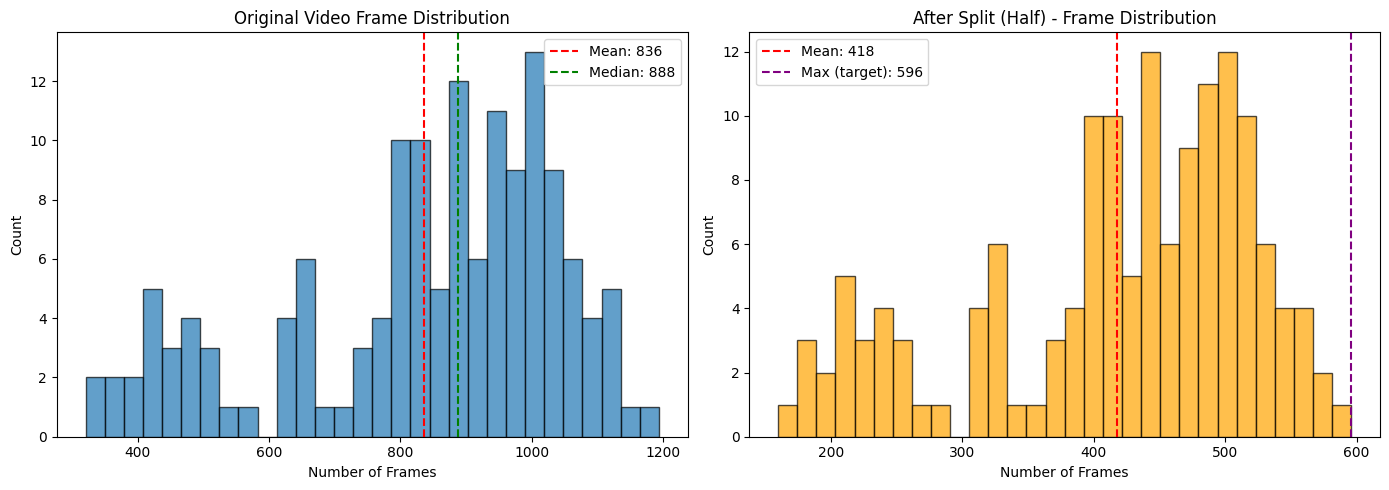


📊 After splitting, videos will have 160 to 596 frames
📊 All will be padded to: 596 frames


In [ ]:
# Visualize frame distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of frame counts
axes[0].hist(df['frames'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(df['frames'].mean(), color='red', linestyle='--', label=f"Mean: {df['frames'].mean():.0f}")
axes[0].axvline(df['frames'].median(), color='green', linestyle='--', label=f"Median: {df['frames'].median():.0f}")
axes[0].set_xlabel('Number of Frames')
axes[0].set_ylabel('Count')
axes[0].set_title('Original Video Frame Distribution')
axes[0].legend()

# After 4-way split (quarter frames)
quarter_frames = df['frames'] // 4
axes[1].hist(quarter_frames, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(quarter_frames.mean(), color='red', linestyle='--', label=f"Mean: {quarter_frames.mean():.0f}")
axes[1].axvline(quarter_frames.max(), color='purple', linestyle='--', label=f"Max (target): {quarter_frames.max():.0f}")
axes[1].set_xlabel('Number of Frames')
axes[1].set_ylabel('Count')
axes[1].set_title('After 4-Way Split - Frame Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 After splitting into 4 clips, videos will have {quarter_frames.min():.0f} to {quarter_frames.max():.0f} frames")
print(f"📊 All will be padded to: {quarter_frames.max():.0f} frames")

## 2. Configure Augmentation

In [ ]:
from dataset_augmentation import AugmentationConfig, DatasetAugmentor

# Configuration
config = AugmentationConfig(
    input_dir="/kaggle/input/viload/drive-download-20260125T111807Z-1-001/dataset_weight_estimation/dataset_weight_estimation",
    output_dir="/kaggle/working/Augmented_Dataset",
    num_splits=4,                 # Split each video into 4 clips
    apply_horizontal_flip=True,   # Apply horizontal flip
    padding_mode="loop",          # Loop video to pad
    output_format="mp4",
    codec="mp4v",
    actions=["walk"]              # Only walk videos (excluding carry)
)

print("Configuration:")
print(f"  Input: {config.input_dir}")
print(f"  Output: {config.output_dir}")
print(f"  Number of splits: {config.num_splits}")
print(f"  Horizontal flip: {config.apply_horizontal_flip}")
print(f"  Padding mode: {config.padding_mode}")
print(f"  Actions: {config.actions}")

# Calculate expected output (72 walk videos × 4 split × 2 flip = 576)
expected_videos = 72 * config.num_splits * (2 if config.apply_horizontal_flip else 1)
print(f"\n📈 Expected output: 72 × {config.num_splits} (split) × 2 (flip) = {expected_videos} videos")

Configuration:
  Input: /kaggle/input/viload/drive-download-20260125T111807Z-1-001/dataset_weight_estimation/dataset_weight_estimation
  Output: /kaggle/working/Augmented_Dataset
  Split ratio: 0.5
  Horizontal flip: True
  Padding mode: loop

📈 Expected output: 144 × 2 (split) × 2 (flip) = 576 videos


## 3. Run Augmentation Pipeline

In [8]:
# Run the augmentation pipeline
augmentor = DatasetAugmentor(config)
summary = augmentor.run()

2026-01-29 21:37:48,826 - INFO - ============================================================
2026-01-29 21:37:48,829 - INFO - Starting Dataset Augmentation Pipeline
2026-01-29 21:37:48,830 - INFO - ============================================================
2026-01-29 21:37:48,870 - INFO - Discovered 144 videos
2026-01-29 21:37:48,871 - INFO - Analyzing video frame counts...
Analyzing videos: 100%|██████████| 144/144 [00:02<00:00, 70.63it/s]
2026-01-29 21:37:50,990 - INFO - Original frame counts: min=321, max=1193, mean=835.6
2026-01-29 21:37:50,991 - INFO - After split: min=160, max=596
2026-01-29 21:37:50,992 - INFO - Target frame count for padding: 596
2026-01-29 21:37:50,993 - INFO - Processing videos...
Augmenting videos: 100%|██████████| 144/144 [09:15<00:00,  3.86s/it]
2026-01-29 21:47:06,294 - INFO - Input videos: 144
2026-01-29 21:47:06,295 - INFO - Output videos: 576
2026-01-29 21:47:06,295 - INFO - Multiplication factor: 4.0x
2026-01-29 21:47:06,296 - INFO - Videos per cla

In [9]:
# Display summary
print("\n" + "=" * 60)
print("✅ AUGMENTATION COMPLETE")
print("=" * 60)
print(f"📁 Original videos: {summary['input_videos']}")
print(f"📁 Augmented videos: {summary['output_videos']}")
print(f"📈 Multiplication factor: {summary['multiplication_factor']}x")
print(f"\n📊 Videos per class:")
for cls, count in summary['videos_per_class'].items():
    print(f"   {cls}: {count}")
print(f"\n🔧 Augmentations applied: {', '.join(summary['augmentations_applied'])}")


✅ AUGMENTATION COMPLETE
📁 Original videos: 144
📁 Augmented videos: 576
📈 Multiplication factor: 4.0x

📊 Videos per class:
   empty: 192
   light: 192
   heavy: 192

🔧 Augmentations applied: split_in_half, resize, horizontal_flip


## 4. Verify Output Dataset

In [10]:
# Verify augmented dataset
output_dir = Path("/kaggle/working/Augmented_Dataset")

augmented_videos = list(output_dir.rglob("*.mp4"))
print(f"Total augmented videos: {len(augmented_videos)}")

# Count by class
class_counts = {}
for video in augmented_videos:
    cls = video.parts[-4]  # class is 4 levels up from file
    class_counts[cls] = class_counts.get(cls, 0) + 1

print("\nVideos per class:")
for cls, count in sorted(class_counts.items()):
    print(f"  {cls}: {count}")

Total augmented videos: 576

Videos per class:
  empty: 192
  heavy: 192
  light: 192


In [11]:
# Verify all videos have same frame count
print("Verifying uniform frame counts...")

frame_counts = []
for video_path in augmented_videos[:50]:  # Check first 50
    cap = cv2.VideoCapture(str(video_path))
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    frame_counts.append(frames)

unique_counts = set(frame_counts)
if len(unique_counts) == 1:
    print(f"✅ All videos have {frame_counts[0]} frames")
else:
    print(f"⚠️ Found varying frame counts: {unique_counts}")

Verifying uniform frame counts...
⚠️ Found varying frame counts: {448, 359, 364, 365, 206, 207, 177, 433, 497, 466, 213, 242, 401, 411, 412, 413}


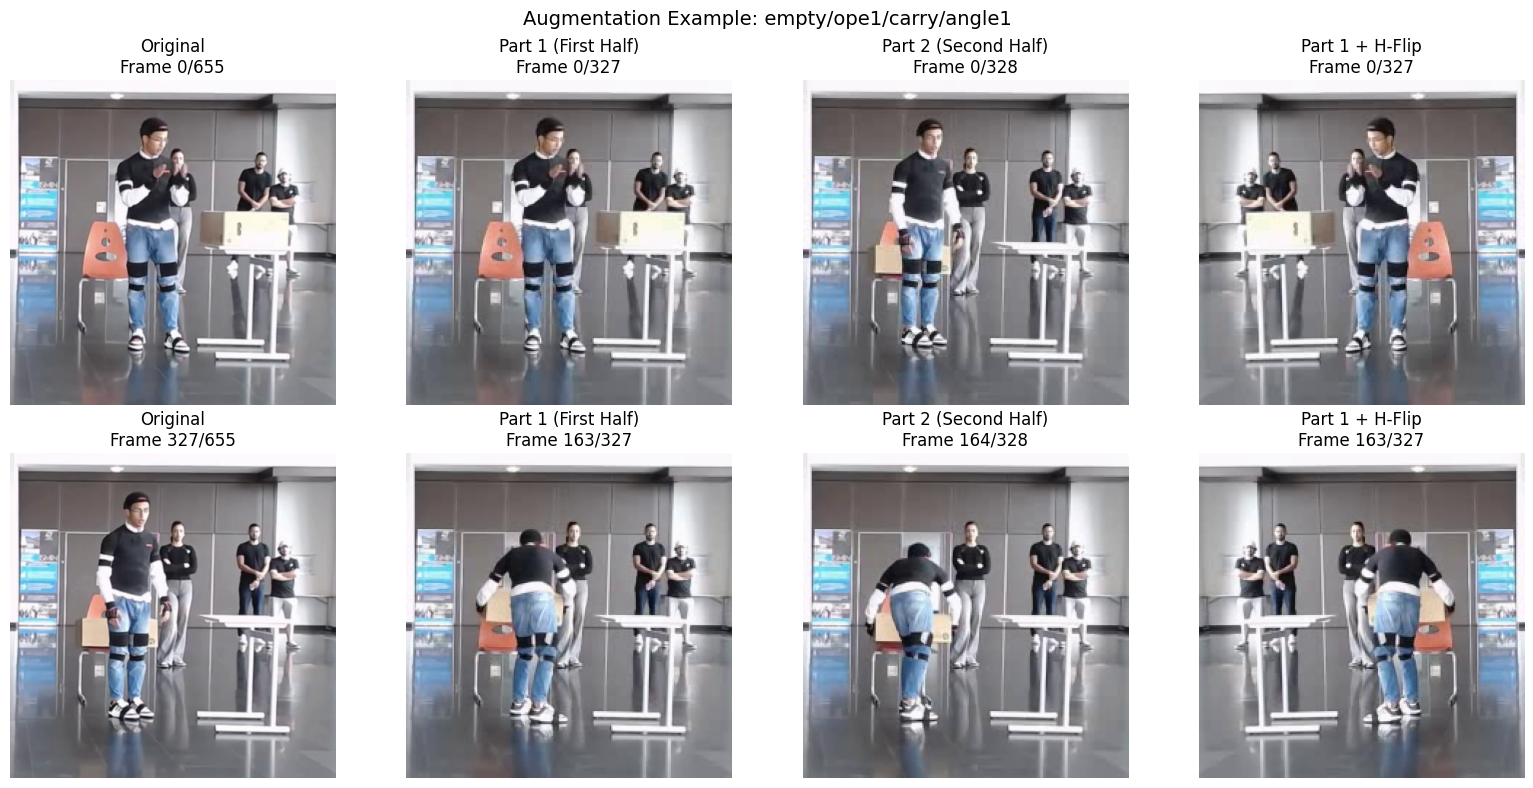

In [ ]:
# Visualize example: original vs split clips vs flipped
def show_video_comparison(original_path, output_dir):
    """Show frames from original and augmented videos."""
    
    # Get paths
    parts = Path(original_path).parts
    cls, ope, action, angle_file = parts[-4], parts[-3], parts[-2], parts[-1]
    angle = angle_file.replace('.mp4', '')
    
    augmented_base = Path(output_dir) / cls / ope / action
    
    # Show all 4 clips
    videos_to_show = [
        (original_path, "Original"),
        (augmented_base / f"{angle}_part1.mp4", "Part 1 (Clip 1)"),
        (augmented_base / f"{angle}_part2.mp4", "Part 2 (Clip 2)"),
        (augmented_base / f"{angle}_part3.mp4", "Part 3 (Clip 3)"),
        (augmented_base / f"{angle}_part4.mp4", "Part 4 (Clip 4)"),
        (augmented_base / f"{angle}_part1_hflip.mp4", "Part 1 + H-Flip"),
    ]
    
    fig, axes = plt.subplots(2, 6, figsize=(20, 7))
    
    for col, (video_path, title) in enumerate(videos_to_show):
        if Path(video_path).exists():
            cap = cv2.VideoCapture(str(video_path))
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            # Show first and middle frame
            for row, frame_idx in enumerate([0, total_frames // 2]):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    axes[row, col].imshow(frame_rgb)
                    axes[row, col].set_title(f"{title}\nFrame {frame_idx}/{total_frames}")
                    axes[row, col].axis('off')
            cap.release()
        else:
            for row in range(2):
                axes[row, col].text(0.5, 0.5, 'Not found', ha='center', va='center')
                axes[row, col].set_title(title)
                axes[row, col].axis('off')
    
    plt.suptitle(f"Augmentation Example: {cls}/{ope}/{action}/{angle}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Show example (using walk action)
example_video = "/kaggle/input/viload/drive-download-20260125T111807Z-1-001/dataset_weight_estimation/dataset_weight_estimation/empty/ope1/walk/angle1.mp4"
show_video_comparison(example_video, "/kaggle/working/Augmented_Dataset")

## 5. Dataset Summary

In [13]:
import json

# Load metadata
with open("/kaggle/working/Augmented_Dataset/dataset_metadata.json", 'r') as f:
    metadata = json.load(f)

print("=" * 60)
print("AUGMENTED DATASET METADATA")
print("=" * 60)
print(f"\n📁 Output directory: {metadata['config']['output_dir']}")
print(f"\n📊 Statistics:")
print(f"   Input videos: {metadata['summary']['input_videos']}")
print(f"   Output videos: {metadata['summary']['output_videos']}")
print(f"   Multiplication: {metadata['summary']['multiplication_factor']}x")

AUGMENTED DATASET METADATA

📁 Output directory: /kaggle/working/Augmented_Dataset

📊 Statistics:
   Input videos: 144
   Output videos: 576
   Multiplication: 4.0x


In [14]:
# Final dataset overview
print("\n" + "=" * 60)
print("📦 FINAL AUGMENTED DATASET")
print("=" * 60)
print(f"\n📍 Location: Augmented_Dataset/")
print(f"📹 Total videos: {len(augmented_videos)}")
print(f"\n📊 Class distribution:")
for cls in ['empty', 'light', 'heavy']:
    count = class_counts.get(cls, 0)
    print(f"   {cls}: {count} videos ({count/len(augmented_videos)*100:.1f}%)")
print(f"\n✅ Ready for training!")


📦 FINAL AUGMENTED DATASET

📍 Location: Augmented_Dataset/
📹 Total videos: 576

📊 Class distribution:
   empty: 192 videos (33.3%)
   light: 192 videos (33.3%)
   heavy: 192 videos (33.3%)

✅ Ready for training!
